In [96]:
# Dependencias básicas
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, TransformerMixin

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px

# Transformación de datos
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from imblearn.over_sampling import SMOTE

# Modelos Sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier

# Evaluación
from sklearn.model_selection import GridSearchCV #probar -> dejar para el fine tunnig
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score


np.random.seed(777)

In [18]:
data_dir = 'data'

In [57]:
def over_sampling(X: np.array, y: np.array) -> tuple:
  sm = SMOTE(random_state = 42)
  return sm.fit_resample(X, y)

def outlier(X: np.array) -> list:
  clf    = LocalOutlierFactor(n_neighbors=20)
  yhat   = clf.fit_predict(X)
  mask   = yhat != -1
  return mask

def TSNE_plot(data: pd.DataFrame):
  X_embedded = TSNE(n_components=2).fit_transform(data)
  plt.scatter(X_embedded[:,0], X_embedded[:,1], c=data.DEATH_EVENT)
  plt.show()

def data_balance_plot(data: pd.DataFrame):
  sns.countplot(x = 'DEATH_EVENT', data = data)

def get_name_clf(clf):
    return clf.__class__.__name__

def neuronal_network(n_features: int):
    clf = Sequential()
    clf.add(Dense(16, activation='relu', input_dim = n_features))
    clf.add(Dense(8, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    clf._estimator_type = "binary_classifier"
    return clf

def print_measure(model: dict):
  print("%s\n\tscore_train: %.3f | score_test: %.3f" %(model["name"],model["AUC_train"], model["AUC_test"]))

In [20]:
k1 = 2
k2 = 6
k3 = 8

classifiers = [
  LogisticRegression(),
  GaussianNB(),
  KNeighborsClassifier(11),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  AdaBoostClassifier(),
  GradientBoostingClassifier()
]

CLASSIFIERS = [(get_name_clf(clf), clf) for clf in classifiers]

NORMALIZATION = [
  ('StandardScaler', StandardScaler()),
  ('Normalizer', Normalizer())
]

FEATURE_EXTRACTION = [
  ('SFS k = %i' %k1, SequentialFeatureSelector(KNeighborsClassifier(n_neighbors = 6), k_features = k1)),
  ('SFS k = %i' %k2, SequentialFeatureSelector(KNeighborsClassifier(n_neighbors = 6), k_features = k2)),
  ('PCA k = %i' %k1, PCA(n_components = 2)),
  ('PCA k = %i' %k2, PCA(n_components = 6)),
  ('KBest - chi k = %i' %k1, SelectKBest(chi2, k=k1)),
  ('KBest - chi k = %i' %k2, SelectKBest(chi2, k=k2))
]

## Data Exploration

In [21]:
data = pd.read_csv('%s/heart_failure_clinical_records_dataset.csv' %(data_dir))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


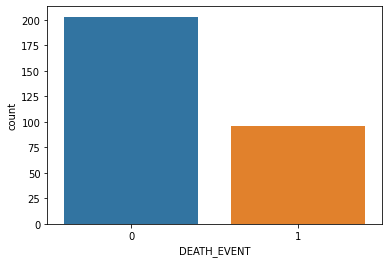

In [58]:
data_balance_plot(data)

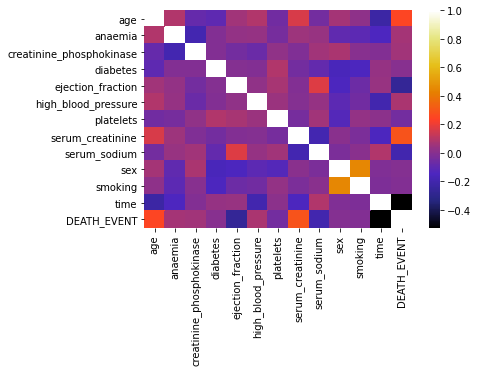

In [23]:
sns.heatmap(data.corr(), cmap="CMRmap")
plt.show() #sacar conclusiones

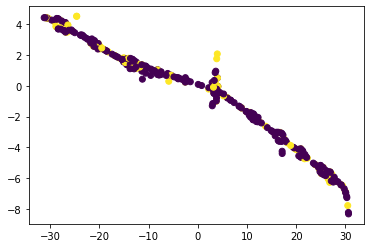

In [24]:
TSNE_plot(data) # sacar conclusi

Pocos outliers 

Distrubución complicada para clasificadores simples

### Data Preparation

In [55]:
class dataset:

  def __init__(self, X: np.array, y: np.array, name: str = "", test_size: int = 15):
    if  not 0 < test_size < 100: 
      raise RuntimeError("Wrong percentage range")
    
    self.name = name
    self.X = X
    self.y = y
    
    self.X_train, self.X_test, self.y_train, self.y_test  = train_test_split(X, y, test_size = test_size/100)

  def split(self) -> tuple:
    return self.X_train, self.X_test, self.y_train, self.y_test

  def create_DataFrame(self) -> pd.DataFrame:
    frame = {
      "C%i" %index: values
      for index, values in enumerate(self.X.transpose())
    }
    frame['DEATH_EVENT'] = self.y
    return pd.DataFrame(
      data = frame,
    )

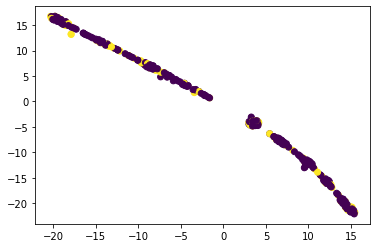

In [61]:
ds_base = dataset(data.values[:, :-1], data.values[:, -1], name = "basic")

mask: list = outlier(ds_base.X)
ds_without_outlier = dataset(ds_base.X[mask, :], ds_base.y[mask], name = "without outlier")
TSNE_plot(ds_without_outlier.create_DataFrame())

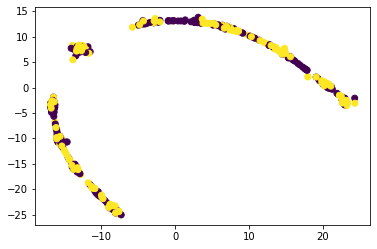

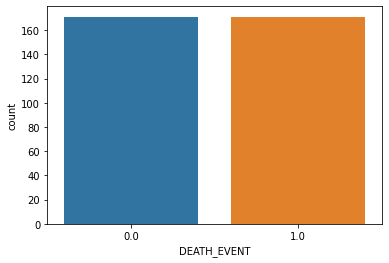

In [63]:
x_aux,y_aux = over_sampling(ds_without_outlier.X, ds_without_outlier.y)
ds_SMOTE = dataset(x_aux, y_aux, name = "SMOTE aumentation")
TSNE_plot(ds_SMOTE.create_DataFrame())
data_balance_plot(ds_SMOTE.create_DataFrame())

DATASETS = [
    ds_base,
    ds_without_outlier,
    ds_SMOTE
]

## Modeling

In [72]:
class Model:

  def __init__(self, pipeline: Pipeline):
    self._pipeline = pipeline
    
    self.estimators        = []
    self.name              = " + ".join(pipeline.named_steps.keys())
    self.auc_measure_train = 0
    self.auc_measure_test  = 0

  def train(self, X_train: np.array, y_train: np.array, cv: int = 5) -> float:
    result = cross_validate(
        self._pipeline, 
        X_train, 
        y_train, 
        cv = cv,
        scoring=('roc_auc'),
        return_estimator = True
      )
    
    self.estimators        = result['estimator']
    self.auc_measure_train = np.mean(result['test_score'])

    return self.auc_measure_train                                       

  def evaluate(self, X_test: np.array,  y_test: np.array) -> float:

    for estimator in self.estimators:
      yhat = estimator.predict(X_test)
      self.auc_measure_test += roc_auc_score(y_test, yhat)
    
    self.auc_measure_test /= len(self.estimators)
    return self.auc_measure_test

  def getMeasure(self) -> dict:
    return {
        "AUC_test": self.auc_measure_test,
        "AUC_train": self.auc_measure_train,
        "name": self.name,
        "estimators": self.estimators
    }

In [28]:
class ModelsCollection:

  def __init__(self):
    self.collection = []

  def add(self, item):
     self.collection.append(item)

  def size(self) -> int:
    return len(self.collection)

  def get(self, index: int) -> Model:
    return self.collection[index]

  def chooseTheBest(self, number: int = 3):
    self.collection.sort(
      key = lambda x: x["AUC_test"],
      reverse = True
    )
    return self.collection[0:number]


In [38]:
class ModelsBuilder:

  def _rules(self, t0, t1) -> bool:
    return not (("KBest" in t0) and t1 == "StandardScaler")

  def __init__(self):

    self.combinations = [[clf] for clf in CLASSIFIERS]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, norm])) 
      for clf in CLASSIFIERS 
      for norm in NORMALIZATION]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, fe])) 
      for clf in CLASSIFIERS 
      for fe in FEATURE_EXTRACTION]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, norm, fe]))
      for clf in CLASSIFIERS 
      for norm in NORMALIZATION 
      for fe in FEATURE_EXTRACTION
      if self._rules(fe[0], norm[0])
    ]

    # Aproximación conecionista

    epochs     = 50
    batch_size = 16
    self.networks = [
      [("NN",KerasClassifier(neuronal_network, n_features=12, epochs=epochs, batch_size=batch_size, verbose=0))],
      [
        ('Normalizer', Normalizer()),
        ('KBest - chi k = %i' %k2, SelectKBest(chi2, k=k2)),
        ("NN",KerasClassifier(neuronal_network, n_features=k2, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('Normalizer', Normalizer()),
        ('KBest - chi k = %i' %k2, SelectKBest(chi2, k=k2)),
        ("NN",KerasClassifier(neuronal_network, n_features=k2, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('Normalizer', Normalizer()),
        ("NN",KerasClassifier(neuronal_network, n_features=12, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('StandardScaler', StandardScaler()),
        ("NN",KerasClassifier(neuronal_network, n_features=12, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('Normalizer', Normalizer()),
        ('PCA k = %i' %k2, PCA(n_components = k2)),
        ("NN",KerasClassifier(neuronal_network, n_features=k2, epochs=epochs, batch_size=batch_size, verbose=0))
      ]
    ]


  def buildClassifiers(self, deep_learning: bool = False):
    pipeline = self.networks if deep_learning else self.combinations
    for pipe in pipeline:
      yield Pipeline(steps=pipe)


builder = ModelsBuilder()

In [64]:
def train_models(deep_learning: bool = False):
    models_data = {}
    for ds in DATASETS:
        models_data[ds.name] = ModelsCollection()
        X_train, X_test, y_train, y_test = ds.split()
        print("\n")
        print("#"*10, ds.name.upper(), "DATASET ", "#"*10, "\n")
        for pipe in builder.buildClassifiers(deep_learning):
            model = Model(pipe)
            model.train(X_train, y_train)
            model.evaluate(X_test, y_test)
            models_data[ds.name].add(model.getMeasure())
        for m in models_data[ds.name].chooseTheBest():
            print_measure(m)
    return models_data

### Machine Learning

In [31]:
ml_results = train_models()



########## BASIC DATASET  ########## 

Normalizer + GradientBoostingClassifier
	score_train: 0.892 | score_test: 0.754
KBest - chi k = 6 + Normalizer + RandomForestClassifier
	score_train: 0.901 | score_test: 0.743
SFS k = 6 + RandomForestClassifier
	score_train: 0.937 | score_test: 0.742


########## WITHOUT OUTLIER DATASET  ########## 

KBest - chi k = 6 + Normalizer + AdaBoostClassifier
	score_train: 0.794 | score_test: 0.911
StandardScaler + GradientBoostingClassifier
	score_train: 0.869 | score_test: 0.895
KBest - chi k = 6 + RandomForestClassifier
	score_train: 0.879 | score_test: 0.895


########## SMOTE AUMENTATION DATASET  ########## 

PCA k = 6 + StandardScaler + GradientBoostingClassifier
	score_train: 0.903 | score_test: 0.917
PCA k = 6 + RandomForestClassifier
	score_train: 0.905 | score_test: 0.913
PCA k = 6 + GradientBoostingClassifier
	score_train: 0.903 | score_test: 0.905


### Deep Learning

In [39]:
dp_result = train_models(deep_learning=True)



########## BASIC DATASET  ########## 

StandardScaler + NN
	score_train: 0.855 | score_test: 0.617
NN
	score_train: 0.532 | score_test: 0.504
Normalizer + KBest - chi k = 6 + NN
	score_train: 0.684 | score_test: 0.500


########## WITHOUT OUTLIER DATASET  ########## 

StandardScaler + NN
	score_train: 0.778 | score_test: 0.779
NN
	score_train: 0.604 | score_test: 0.553
Normalizer + KBest - chi k = 6 + NN
	score_train: 0.624 | score_test: 0.500


########## SMOTE AUMENTATION DATASET  ########## 

StandardScaler + NN
	score_train: 0.872 | score_test: 0.888
Normalizer + KBest - chi k = 6 + NN
	score_train: 0.531 | score_test: 0.500
Normalizer + KBest - chi k = 6 + NN
	score_train: 0.633 | score_test: 0.500


## Comparative

In [33]:
def build_comparatie_plots(index: int, curve_data: list, title: str, X_test: np.array, y_test: np.array) -> None:
      plt.figure(index)
      tprs = []
      aucs = []
      mean_fpr = np.linspace(0, 1, 100)

      fig, ax = plt.subplots()
      for i,model in enumerate(curve_data['estimators']):
            viz = plot_roc_curve(model, X_test, y_test,
                              name='ROC fold {}'.format(i),
                              alpha=0.3, lw=1, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

      ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

      mean_tpr = np.mean(tprs, axis=0)
      mean_tpr[-1] = 1.0
      mean_auc = curve_data['AUC_test']
      std_auc  = np.std(aucs)
      ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

      std_tpr = np.std(tprs, axis=0)
      tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
      tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
      ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

      ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
            title=title)
      ax.legend(loc="lower right")
      # Here is the trick
      plt.gcf()
      handles, labels = plt.gca().get_legend_handles_labels()
      handles = handles[6:]
      labels = labels[6:]
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys())
      plt.show()

In [34]:
for ds in DATASETS:
    _, X_test, _, y_test = ds.split()
    for index, est in enumerate(models_data[ds.name].chooseTheBest()):
        print_measure(est)
        build_comparatie_plots(
        index, 
            est, 
            "%s + %s" % (ds.name, est['name']),
            X_test,
            y_test
        )


NameError: name 'models_data' is not defined

## Fine tuning

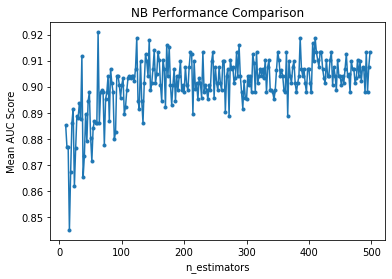

PCA k = 6 + RandomForestClassifier 62
	score_train: 0.897 | score_test: 0.921


In [100]:
ds = DATASETS[2]
X_train, X_test, y_train, y_test = ds.split()
rf_list = ModelsCollection()
tunnig  = np.arange(10,500,2)
for trees in tunnig:
    model = Model(Pipeline(
        steps=[
            ('PCA k = %i' %k2, PCA(n_components = k2)),
            ("RandomForestClassifier %i" % trees, RandomForestClassifier(n_estimators = trees))
        ]
    ))
    model.train(X_train, y_train)
    model.evaluate(X_test, y_test)
    rf_list.add(model.getMeasure())

maximun = max(rf_list.collection, key = lambda x: x['AUC_test'])

plt.plot(tunnig, [ rf['AUC_test'] for rf in rf_list.collection], marker = '.') 
plt.xlabel('n_estimators')
plt.ylabel("Mean AUC Score")
plt.title("NB Performance Comparison")
plt.show()
print_measure(maximun)